# **Modelagem Matemática e Computacional - Aula prática 15**
### Nome: Riquelme Freitas Gomes
### Data: 04/12/2023
<br>

# **Objetivo:**
> ### Estudar e pôr em prática a modelagem matemática e a análise de dados utilizando o PySINDy.

# **SINDy**

> #### SINDy significa Identificação Esparsa de Dinâmica Não Linear. É um método baseado em dados para descobrir modelos de sistemas dinâmicos a partir de dados de medição, utilizando regressão esparsa.

## **Identificação de Sistema**

#### Identificação de sistema refere-se ao processo de utilizar dados de medição para inferir equações governantes, na forma de sistemas dinâmicos, que descrevem os dados. Uma vez descobertas, essas equações podem fazer previsões sobre estados futuros, informar entradas de controle ou possibilitar o estudo teórico usando técnicas analíticas. Sistemas dinâmicos são uma classe flexível e bem estudada de objetos matemáticos para modelar sistemas que evoluem no tempo. SINDy é um método de descoberta de modelo que utiliza regressão esparsa para inferir sistemas dinâmicos não lineares a partir de dados de medição. Os modelos resultantes são inherentemente interpretáveis e generalizáveis.

## **Como funciona**

#### Suponha que, para algum sistema físico de interesse, tenhamos medições das variáveis de estado $x(t)$ (um vetor de comprimento $n$) em diferentes pontos no tempo. Exemplos de variáveis de estado incluem a posição, velocidade ou aceleração de objetos; sustentação, arrasto ou ângulo de ataque de objetos aerodinâmicos; e concentrações de diferentes espécies químicas. Se suspeitarmos que o sistema pode ser bem modelado por um sistema dinâmico da forma $$ x'(t) = f(x(t)), $$

#### então podemos usar o SINDy para aprender $f(x)$ a partir dos dados ($x'(t)$ denota a derivada temporal de $x(t)$). Note que tanto $f(x)$ quanto $x(t)$ são tipicamente vetores. A suposição fundamental que o SINDy utiliza é que cada componente de $f(x)$, $f_i(x)$, pode ser representada como uma combinação linear esparsa de funções de base $theta_j(x)$ $$ f_i(x) = theta_1(x) * xi_{1,i} + theta_2(x) * xi_{2,i} + ... + theta_k * xi{k,i} $$

#### Concatenar todos os objetos em matrizes (denotadas com nomes em maiúsculas) ajuda a simplificar as coisas. Para isso, colocamos todas as medições das variáveis de estado em uma matriz de dados $X$ (com uma linha por medição de tempo e uma coluna por variável), as derivadas das variáveis de estado em uma matriz $X'$, todas as funções de base avaliadas em todos os pontos no tempo em uma matriz $Theta(X)$ (cada função de base recebe uma coluna) e todos os coeficientes em uma terceira matriz $Xi$ (uma coluna por variável de estado). O problema de aproximação a ser resolvido pode então ser escrito de forma compacta como $$ X' = Theta(X) * Xi. $$

#### Cada linha desta equação de matriz corresponde a uma função de coordenada de f(x). O SINDy emprega técnicas de regressão esparsa para encontrar uma solução Xi com vetores de coluna esparsos.

## **Ideias principais**

#### Suponha que tenhamos um conjunto de medições $ \mathbf{x}(t) $ pertencentes a $ \mathbb{R}^n $ de algum sistema físico em diferentes pontos no tempo $ t $. O SINDy tenta representar a evolução temporal de $ \mathbf{x}(t) $ em termos de uma função não linear $ \mathbf{f} $: $$\frac{d}{dt}x(t) = \mathbf{f}(\mathbf{x}(t))$$

#### Essa equação constitui um sistema dinâmico para as medições $\mathbf{x}(t) $. O vetor $\mathbf{x}(t) = [\mathbf{x}_1(t), \mathbf{x}_2(t), \ldots, \mathbf{x}_n(t)]^T $ representa o estado do sistema físico no tempo $ t $. A função $\mathbf{f}(\mathbf{x}(t)) $ determina como o sistema evolui no tempo.

#### A ideia fundamental por trás do SINDy é que a função $ \mathbf{f} $ é frequentemente esparsa no espaço de um conjunto apropriado de funções de base. Por exemplo, a função

$$ \frac{d}{dt}x = \mathbf{f}(\mathbf{x}) = \begin{bmatrix} \mathbf{f}_1(\mathbf{x}) \\ \mathbf{f}_2(\mathbf{x}) \end{bmatrix} = \begin{bmatrix} -2 + \mathbf{x}_1^2 + 3\mathbf{x}_1\mathbf{x}_2 \\ 7\mathbf{x}_2^4 - 2\mathbf{x}_1^3 \end{bmatrix} $$

#### é esparsa em relação ao conjunto de polinômios de duas variáveis, no sentido de que se escrevêssemos uma expansão das funções componentes de $ \mathbf{f} $ nessa base (por exemplo, $ \mathbf{f}_1(\mathbf{x}) = \sum_{i=0}^{\infty} \sum_{j=0}^{\infty} a_{i,j} \mathbf{x}_1^i \mathbf{x}_2^j $), apenas um pequeno número de coeficientes $( a_{i,j} $) seriam diferentes de zero.

<br>

#### O SINDy utiliza **regressão esparsa** para encontrar uma combinação linear de funções de base que captura melhor o comportamento dinâmico do sistema físico.

# **Experimentos com os códigos disponibilizados**

In [2]:
pip install pysindy

O trecho de código em Python a seguir importa bibliotecas e módulos relacionados à análise e visualização de sistemas dinâmicos, especialmente aqueles usados com a biblioteca PySINDy (Symbolic-Regression-Informed Nonlinear Dynamics), que é uma ferramenta para descoberta de equações diferenciais a partir de dados.

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz

import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

## **Sistemas Ilustrativos Simples**

Aqui apresentamos exemplos de SINDy aplicado a sistemas dinâmicos lineares e não lineares simples. Em cada caso, o objeto `SINDy` recebe medições das variáveis de estado, mas não de suas derivadas, e tem a tarefa de identificar as equações que descrevem sua dinâmica.

### EDO Linear 2D

O primeiro exemplo mostra uma demonstração do SINDy em um oscilador harmônico linear amortecido bidimensional.

Geramos dados de treinamento integrando o seguinte sistema linear de equações diferenciais com condição inicial $(2,0)$.

$$ \frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix} $$

In [4]:
# Generate training data

dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(linear_damped_SHO, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

Em seguida, ajustamos um modelo SINDy aos dados de treinamento, constatando que ele recupera as equações governantes corretas.

In [5]:
# Fit the model

poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1


O modelo aprendido pode ser usado para evoluir condições iniciais ao longo do tempo. Aqui, plotamos as trajetórias previstas pelo modelo SINDy em comparação com aquelas das verdadeiras equações governantes.

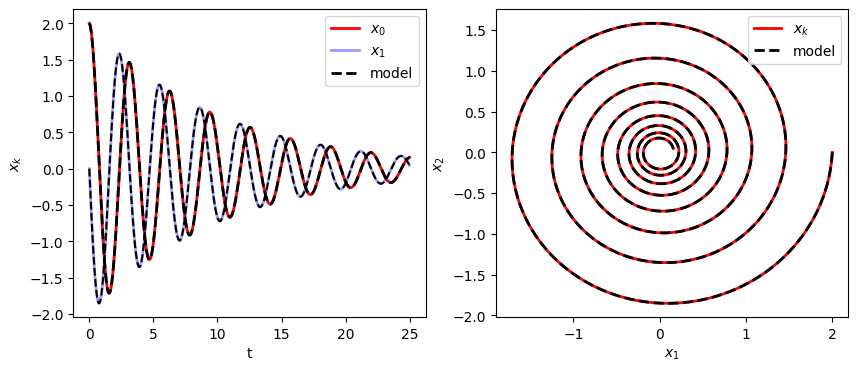

In [6]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

Esse código realiza a simulação e a plotagem dos resultados para comparar as trajetórias reais (dados de treinamento) com as trajetórias simuladas pelo modelo SINDy. Podemos ver que os resultados obtidos são bem próximos aos dados reais.

### EDO Cúbica 2D

O SINDy também pode identificar um oscilador harmônico amortecido bidimensional *não linear*. Este exemplo envolve dinâmicas cúbicas. O sistema governante usado para gerar dados de treinamento é o seguinte. É idêntico ao exemplo anterior, exceto que os termos lineares no lado direito foram substituídos por termos cúbicos.

$$ \frac{d}{dt}\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}-0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x^3 \\ y^3\end{bmatrix} $$

In [7]:
# Generate training data

dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(cubic_damped_SHO, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T


# Fit the model

poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.100 x0^3 + 1.999 x1^3
(x1)' = -1.999 x0^3 + -0.100 x1^3


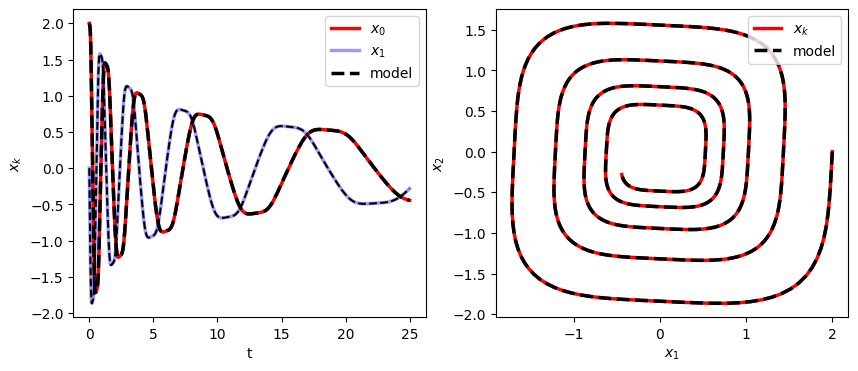

In [8]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2.5)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

Os resultados visuais permitem a comparação direta entre as trajetórias reais e simuladas, proporcionando uma avaliação visual da qualidade do modelo SINDy na representação das dinâmicas cúbicas do sistema estudado. Se as trajetórias simuladas se alinharem bem com as trajetórias reais, isso indicará que o modelo é eficaz na captura da dinâmica não linear do sistema.

### EDO Linear 3D

O último exemplo desta seção mostra a aplicação do SINDy para identificar um sistema linear em três dimensões. As equações governantes são fornecidas pelo seguinte sistema.

$$ \frac{d}{dt}\begin{bmatrix}x \\ y \\ z \end{bmatrix} = \begin{bmatrix}-0.1 & -2 & 0 \\ 2 & -0.1 & 0 \\ 0 & 0 & -0.3 \end{bmatrix} \begin{bmatrix}x \\ y \\ z \end{bmatrix} $$

In [9]:
# Generate training data

dt = .01
t_train = np.arange(0, 50, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0, 1]
x_train = solve_ivp(linear_3D, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

# Fit the model

poly_order = 5
threshold = 0.01

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1
(x2)' = -0.300 x2


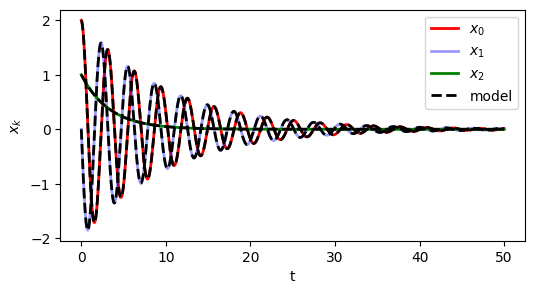

In [17]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(6, 3))
plt.plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
plt.plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
plt.plot(t_train, x_train[:, 2], "g", label="$x_2$", **plot_kws)
plt.plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
plt.plot(t_train, x_sim[:, 1], "k--", **plot_kws)
plt.plot(t_train, x_sim[:, 2], "k--", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

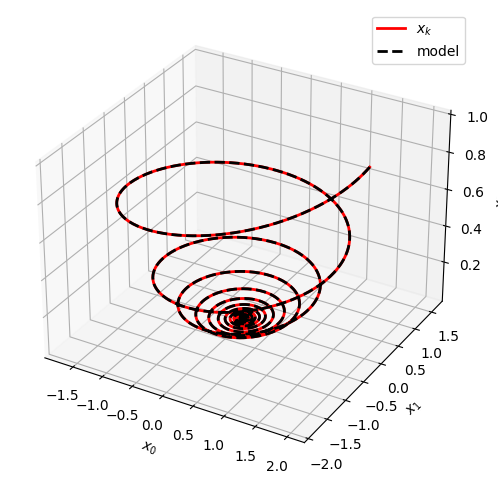

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

## Sistema de Lorenz (EDO não linear)

O sistema de Lorenz serve como exemplo de uma EDO não linear cujas soluções exibem dinâmicas caóticas evoluindo em um atrator estranho. O sistema de Lorenz é dado por

$$ \begin{aligned} \dot x &= \sigma(y-x)\\ \dot y &= x(\rho - z) - y \\ \dot z &= xy - \beta z, \end{aligned} $$

com $\sigma=10$, $\rho=28$, e $\beta=\tfrac{8}{3}$ para este exemplo. Geramos nossos dados de treinamento a partir da condição inicial $(-8, 8, 27)$. Observe que, para este exemplo, também coletamos medições das derivadas das variáveis de estado, $(\dot x, \dot y, \dot z)$.

In [19]:
# Generate training data

dt = 0.001
t_train = np.arange(0, 100, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T
x_dot_train_measured = np.array(
    [lorenz(0, x_train[i]) for i in range(t_train.size)]
)

### Medir estados $x$ e derivadas $\dot{x}$

Neste exemplo, tanto os estados $x$ quanto as derivadas $\dot{x}$ do sistema de Lorenz são medidas, e níveis crescentes de ruído ($\eta$) são adicionados às derivadas.

In [21]:
# Fit the models and simulate

poly_order = 5
threshold = 0.05

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

models = []
t_sim = np.arange(0, 20, dt)
x_sim = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(
        x_train,
        t=dt,
        x_dot=x_dot_train_measured
        + np.random.normal(scale=eps, size=x_train.shape),
        quiet=True,
    )
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))

[Text(0.5, 0, '$x$'), Text(0.5, 0.5, '$y$'), Text(0.5, 0, '$z$')]

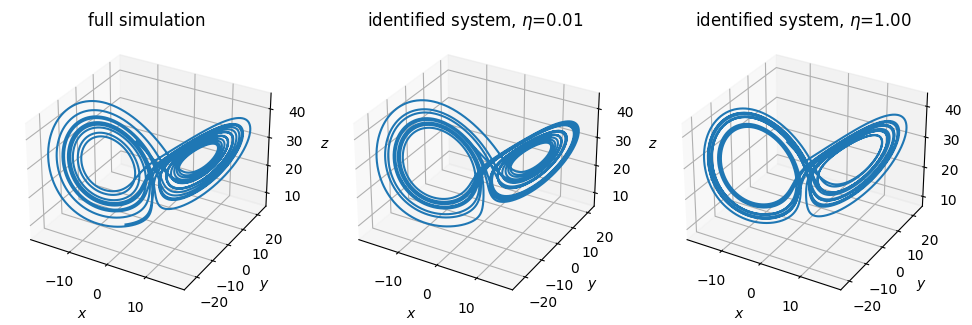

In [27]:
# Plot results

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_sim.size, 0],
    x_train[: t_sim.size, 1],
    x_train[: t_sim.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(133, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

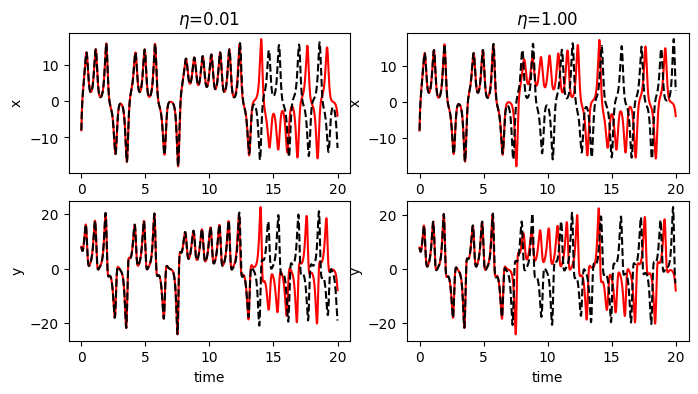

In [31]:
fig = plt.figure(figsize=(8, 4))
model_idx = 2
ax = fig.add_subplot(221)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(223)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

model_idx = 4
ax = fig.add_subplot(222)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(224)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

fig.show()

### Medir apenas os estados $x$, calcular as derivadas

Neste exemplo, apenas os estados $x$ são medidos e ruído em diferentes níveis é adicionado aos estados. As derivadas são calculadas a partir das medições ruidosas dos estados usando um esquema de diferença central.

In [32]:
# Fit the models and simulate

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

models_noD = []
t_sim = np.arange(0, 20, dt)
x_sim_noD = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(x_train + np.random.normal(scale=eps, size=x_train.shape),
              t=dt, quiet=True)
    models_noD.append(model)
    x_sim_noD.append(model.simulate(x_train[0], t_sim))

### Comparar os erros em cada caso

Aqui, plotamos o erro em função do tempo para diferentes níveis de ruído.

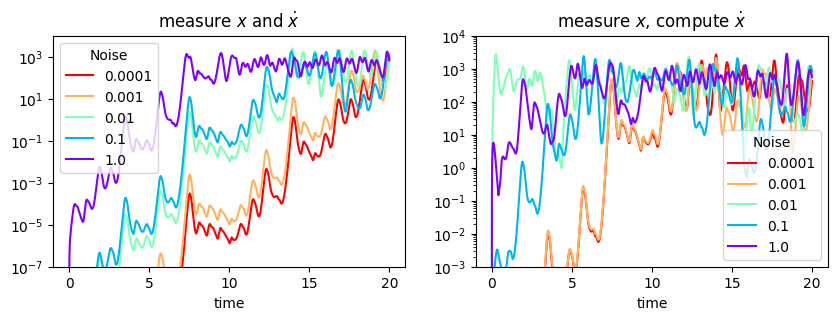

In [36]:
colors = rainbow(np.linspace(1, 0, len(models)))

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
for i, x in enumerate(x_sim):
    axs[0].semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )
axs[0].set(xlabel="time", title="measure $x$ and $\dot{x}$")
axs[0].legend(title="Noise")
axs[0].set_ylim(1e-7, 1e4)

for i, x in enumerate(x_sim_noD):
    axs[1].semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )

axs[1].set(xlabel="time", title="measure $x$, compute $\dot{x}$")
axs[1].legend(title="Noise")
axs[1].set_ylim(1e-3, 1e4)

fig.show()


   - Em ambos os gráficos, é possível observar como o erro evolui ao longo do tempo para diferentes níveis de ruído.
   - Comparando os dois gráficos, podemos avaliar como a escolha entre medir diretamente as derivadas ou calcular as derivadas a partir das medições afeta a precisão do modelo em diferentes condições de ruído.
   - Os níveis de ruído mais altos geralmente levam a erros mais elevados, e a escala logarítmica ajuda a destacar essas diferenças, especialmente em situações de baixo erro.
   - A legenda fornece uma referência visual para os níveis de ruído em cada curva, facilitando a compreensão de como o ruído influencia o desempenho do modelo ao longo do tempo.

# **Conclusão**

#### Em conclusão, a abordagem de modelagem matemática e análise de dados utilizando o PySINDy demonstrou ser uma ferramenta poderosa e versátil. A capacidade de extrair dinâmicas subjacentes de sistemas complexos a partir de dados observacionais oferece uma maneira eficaz de compreender e representar matematicamente fenômenos diversos. O PySINDy, ao implementar o Sparse Identification of Nonlinear Dynamics, proporciona uma solução eficiente para descobrir modelos dinâmicos a partir de dados de medição, apresentando uma abordagem interpretável e generalizável.

#### A aplicação do PySINDy em diversos exemplos, como sistemas lineares e não lineares, destacou sua adaptabilidade a diferentes contextos. A capacidade de lidar com diferentes níveis de ruído e a opção de medir diretamente as derivadas ou calculá-las a partir dos dados mostraram-se aspectos valiosos na modelagem de sistemas do mundo real.

# **Fontes e referências**

1. SINDy. https://deeptime-ml.github.io/latest/notebooks/sindy.html#Main-ideas
2. PySINDy. https://deeptime-ml.github.io/latest/notebooks/sindy.html#Main-ideas
3. Discovering governing equations from data by sparse identification of nonlinear dynamical systems. https://www.pnas.org/doi/10.1073/pnas.1517384113